In [133]:
# generate the GWAS data for testing the variationl bayes methods
import numpy as np
import pandas as pd
from math import exp

# data shape
p = 1000
true_p = 20
n = 500

maf = np.random.uniform(0.05, 0.5, p)
snps = np.empty(shape = (n, p))

for ind, f in np.ndenumerate(maf):
	snps[:, ind[0]] = np.random.binomial(2, f, n)

# normalize snps
snps = (snps - snps.mean(axis = 0)) / snps.std(axis = 0)

# generate genotypes
# select a subset to be in the true model
true_id = np.arange(1, true_p + 1)
true_snps = snps[:, true_id]
true_beta = np.random.normal(0, 1, len(true_id))
print(true_beta)

# create gene expression levels
true_snps = np.array(true_snps)
true_beta = np.array(true_beta)

geno = np.sum(true_snps * true_beta, axis = 1) + np.random.normal(0, 3)
print(geno)

geno = pd.DataFrame(geno)
snps = pd.DataFrame(snps)

# write the data in hdf5 format for faster reading
snps.to_hdf('data/snps.h5', 'data', mode='w', format='fixed')
geno.to_hdf('data/geno.h5', 'data', mode='w', format='fixed')

# save the true parameters
actual = pd.DataFrame({
	'snp_id': true_id
	,'beta': true_beta 
	})

actual.to_hdf('data/actual.h5', 'data', mode='w', format='fixed')


[ 1.08636736  1.04187293 -0.2154722  -1.01193967  0.42589873 -0.2862957
  0.35850841 -0.95234208 -0.79618708 -0.59464729 -0.17667937  1.01964177
 -1.54236469  2.21976252 -0.58204028 -0.56904276 -1.19234728  0.67486636
 -0.51447393  1.52750302]
[ -8.00912499e-01   4.15140461e+00  -2.44805355e+00  -1.06274848e+00
   6.42829263e+00  -9.22599127e-01  -1.53353514e+00   3.38449097e+00
   6.05204999e+00   1.43534037e+00   6.04854446e+00  -1.59869947e-01
  -4.93587550e+00  -1.25296349e+00  -2.46997536e+00   3.96482470e+00
  -5.76177612e+00  -1.16984017e+00   4.56538079e+00   1.55014403e+00
  -1.37080441e+00   2.24960508e+00   2.67726092e+00  -3.28922997e+00
  -1.27056895e+00  -6.16556587e-01  -4.41170068e+00  -1.41266444e+00
   1.75620171e+00   4.76491958e+00   1.58032332e+00   1.22162557e+00
  -6.82588808e-01   4.44407555e-01   4.26277926e+00   1.35237235e-02
  -1.67477191e-02   3.42825825e+00   7.77886301e+00  -1.13795281e+00
   1.91245314e+00   1.40191092e+00  -1.83306402e+00   4.22353705e+

In [119]:
from pystan import StanModel

 # Begin Stan section
gwas_code = '''
data {
	// dimensions of the data
	int<lower = 0> N;
	int<lower = 0> P;

	// predictors (x) and target (y)
	matrix[N, P] x;
	vector[N] y;
}

parameters {
	// regression coefficients
	vector[P] beta;
    real sigma;

	// horseshoe prior parameters
	vector<lower = 0>[P] lambda;
	vector<lower = 0>[P] eta;
    real<lower = 0> tau;
}

model {
    // beta hierarchy
	tau ~ cauchy(0, 1);
	eta ~ cauchy(0, 1);
	lambda ~ cauchy(0, tau * eta);
	beta ~ normal(0, lambda);

    // sigma
    sigma ~ gamma(2, 0.5);
    // sigma ~ student_t(4, 0, 1);
    
	// construct model 
	y ~ normal(x * beta, sigma);
}
'''
model = StanModel(model_code = gwas_code)
print("Finished")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3fc570b024d70f8092cbf1348963ef59 NOW.


Finished


In [134]:
# read in previously generated data
geno = pd.read_hdf('data/geno.h5')
snps = pd.read_hdf('data/snps.h5')

geno = geno.values.flatten()
snps = snps.values

n = snps.shape[0]
p = snps.shape[1]

gwas_data = {
		'N': n
		,'P': p
		,'y': geno
		,'x': snps
	}

# ADVI using stochastic gradient descent
fit_advi = model.vb(data = gwas_data
	,output_samples = 1000
	,iter = 40000
	,eval_elbo = 250
	,tol_rel_obj = 0.01
	,algorithm = 'meanfield')

# read in the posterior draws for each parameter
param_file = fit_advi['args']['sample_file'].decode("utf-8")
advi_coef = pd.read_csv(param_file, skiprows = [0, 1, 2, 3, 5, 6])

# relabel to have the actual indicies of the betas after the split
betas = advi_coef.filter(like = "beta")
betas.columns = ["beta." + str(j) for j in range(0, p)]

# save coefficients in hdf5 format
betas.to_hdf('data/betas.h5', 'data', mode='w', format='fixed')

# save other estimates in hdf5
param = advi_coef.filter(regex = "^(?!beta).*$")
param.to_hdf('data/param.h5', 'data', mode='w', format='fixed')

print("Finished")

Finished


        beta  snp_id
0   1.086367       1
1   1.041873       2
2  -0.215472       3
3  -1.011940       4
4   0.425899       5
5  -0.286296       6
6   0.358508       7
7  -0.952342       8
8  -0.796187       9
9  -0.594647      10
10 -0.176679      11
11  1.019642      12
12 -1.542365      13
13  2.219763      14
14 -0.582040      15
15 -0.569043      16
16 -1.192347      17
17  0.674866      18
18 -0.514474      19
19  1.527503      20
       lower    median     upper
0   1.920220  2.170610  2.403780
1   1.320960  1.553750  1.789450
2  -1.803840 -1.530660 -1.276930
3  -1.414370 -1.159740 -0.932618
4   0.794445  1.045190  1.298770
5  -1.274900 -1.007290 -0.752197
6   0.787194  1.006750  1.224920
7   0.696273  0.946132  1.187750
8  -1.187670 -0.933551 -0.701516
9  -0.926334 -0.714098 -0.476893
10  0.370600  0.578659  0.795373
11 -0.793320 -0.555506 -0.308625
12 -0.757754 -0.522833 -0.291253
13 -0.727125 -0.454773 -0.196357
14 -0.671719 -0.449649 -0.223553
15  0.147924  0.388869  0.66390

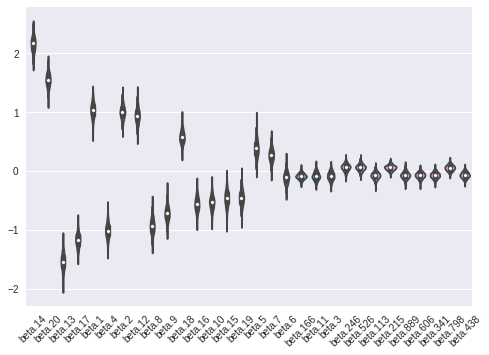

In [174]:
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

raw_betas = pd.read_hdf('data/betas.h5')

n = raw_betas.shape[0]
p = raw_betas.shape[1]
true_p = 5

# print the actual values
actual = pd.read_hdf('data/actual.h5')
print(actual)

# unadjusted
betas = raw_betas.median(axis = 0)
top_betas = abs(betas).sort_values()[-30:][::-1]

beta_index = list(top_betas.index)
top_betas = raw_betas.filter(items = beta_index)

# compute posterior quantiles to create credible intervals
quants = np.apply_along_axis(np.percentile, 0, top_betas, [2.5, 50, 97.5])
print(pd.DataFrame({'lower': quants[0],'median': quants[1], 'upper': quants[2]}))


sb.violinplot(data = top_betas)
sb.plt.xticks(rotation = 45)
sb.plt.show()


In [3]:
# read in previously generated data
geno = pd.read_hdf('data/geno.h5')
snps = pd.read_hdf('data/snps.h5')

geno = geno.values.flatten()
snps = snps.values

n = snps.shape[0]
p = snps.shape[1]

gwas_data = {
		'N': n
		,'P': p
		,'y': geno
		,'x': snps
	}

# HMC 
fit_hmc = model.sampling(data = gwas_data
                         ,thin = 2
                         ,n_jobs = -1)
print(fit_hmc)


Inference for Stan model: anon_model_fd455faad699c416125c8269a7fa1dbe.
4 chains, each with iter=2000; warmup=1000; thin=5; 
post-warmup draws per chain=200, total post-warmup draws=800.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]    -1.9e-3    0.01   0.08  -0.19  -0.01-3.9e-3   0.01   0.21     55   1.06
beta[1]       2.66    1.95   2.76  -0.05 3.2e-3   1.48   4.87   7.85      2    5.7
beta[2]       8.83    2.46   3.48   1.25   5.45  10.35  11.14  13.03      2   4.82
beta[3]       5.78    4.11   5.82  -0.09-9.2e-4   4.93  11.43  13.35      2  11.72
beta[4]       5.77    4.14   5.85  -0.02 1.8e-3    4.8  10.81  13.68      2  12.15
beta[5]      10.19    4.19   5.92-2.8e-4   5.08   13.0   13.9  15.42      2   9.31
beta[6]      -0.12    0.08    0.2  -0.59  -0.27-1.7e-3 4.2e-3   0.04      7   3.18
beta[7]      -0.04    0.02   0.11  -0.34  -0.05-7.5e-3   0.02   0.14     24   1.25
beta[8]       0.03    0.02   0.13  -0.27-9.1e-3 4.6e-3   0.06   0.

In [31]:
log_name = 'logs/hmc_beta_dist_as_N(7, 1)'
with open(log_name, "w") as f:
    f.write(str(fit_hmc))